In [1]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
from torchvision.io import read_video

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [2]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

time_window = 5
patch_size = (35, 35)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h

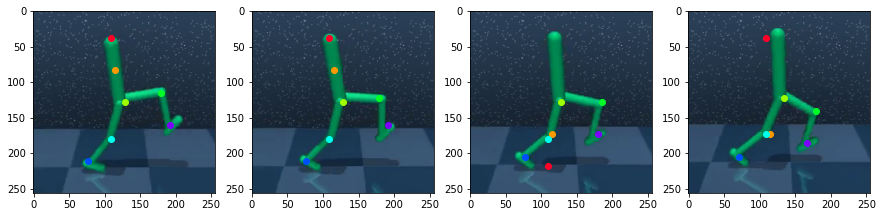

In [3]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = bad_kpt_coordinates.shape

cm = pylab.get_cmap('gist_rainbow')
bad_kpts = kpts_2_img_coordinates(bad_kpt_coordinates, tuple(img_tensor.shape[-2:]))
fig, ax = plt.subplots(1, sample_size, figsize=(15, 5))
for t in range(sample_size):
    ax[t].imshow(img_tensor[0, t].permute(1, 2, 0))
    for k in range(K):
        ax[t].scatter(bad_kpts[0, t, k, 1], bad_kpts[0, t, k, 0], color=cm(1.*k/K))
plt.show()

torch.Size([16, 4, 3, 256, 256])
torch.Size([16, 4, 7, 3])
torch.Size([16, 4, 7, 3, 32, 32])


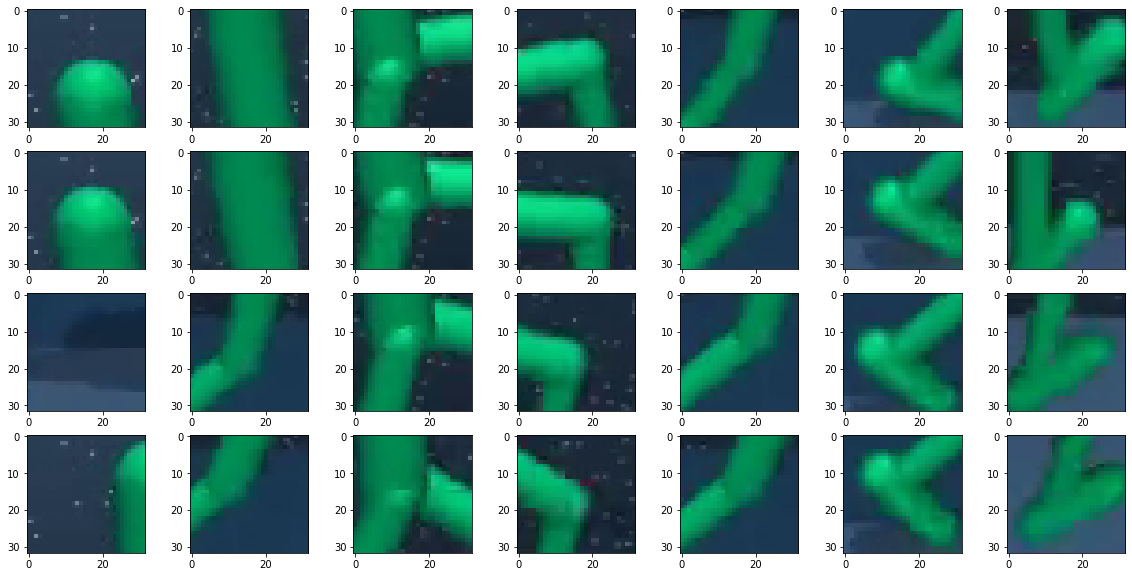

In [4]:
print(img_tensor.shape)  # (N, T, C, H, W)
print(bad_kpt_coordinates.shape)  # (N, T, K, D)

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

print(bad_kpt_patches.shape)  # (N, T, K, C, H', W')
Hp, Wp = bad_kpt_patches.shape[-2:]

fig, ax = plt.subplots(T, K, figsize=(20, 10))
for t in range(T):
    for k in range(K):
        ax[t, k].imshow(bad_kpt_patches[0, t, k, ...].permute(1, 2, 0).cpu().numpy())

MKD descriptor vectors of the patches

In [5]:
from kornia.feature import TFeat, MKDDescriptor, SIFTFeature

bad_kpt_patches = bad_kpt_patches.view((N*T*K*C, 1, Hp, Wp))
desc = MKDDescriptor(patch_size=Hp, output_dims=32)
bad_kpt_fts = desc(bad_kpt_patches).view((N, T, C, K, 32))
print(bad_kpt_fts.shape)

torch.Size([16, 4, 3, 7, 32])


torch.Size([16, 4, 7, 7])


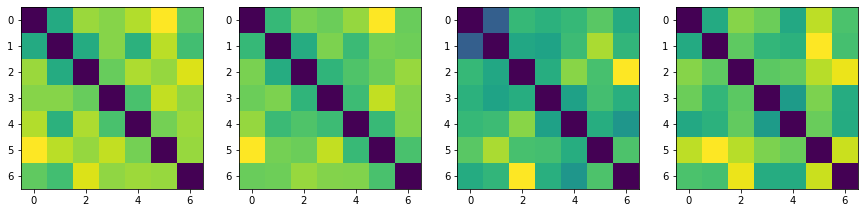

In [6]:
# Key-point difference tensor for bad key-points

ft_kpt_dist = torch.norm(bad_kpt_fts.unsqueeze(3) - bad_kpt_fts.unsqueeze(4), p=2, dim=-1)**2
ft_kpt_dist = torch.mean(ft_kpt_dist, dim=2)
print(ft_kpt_dist.shape)


fig, ax = plt.subplots(1, T, figsize=(15, 10))
for t in range(T):
    ax[t].imshow(ft_kpt_dist[0, t, :, :].detach().cpu().numpy())
plt.show()

torch.Size([16, 4, 4, 7])


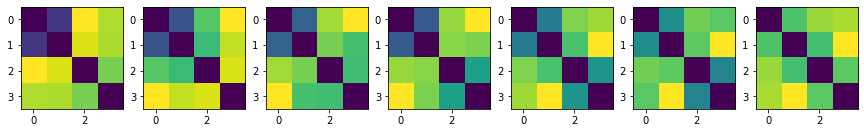

In [7]:
# Temporal difference tensor for bad key-points

ft_t_dist = torch.norm(bad_kpt_fts.unsqueeze(1) - bad_kpt_fts.unsqueeze(2), p=2, dim=-1)**2
ft_t_dist = torch.mean(ft_t_dist, dim=-2)
print(ft_t_dist.shape)

fig, ax = plt.subplots(1, K, figsize=(15, 10))
for k in range(K):
    ax[k].imshow(ft_t_dist[0, :, :, k].detach().cpu().numpy())
plt.show()

In [8]:
# Perfect key-points

perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))
perfect_kpt_patches = perfect_kpt_patches.view((N*T*K*C, 1, Hp, Wp))
perfect_kpt_fts = desc(perfect_kpt_patches).view((N, T, C, K, 32))

torch.Size([16, 4, 4, 7])


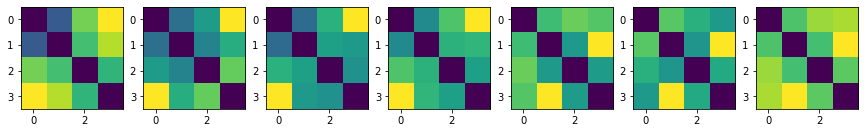

In [9]:
ft_t_dist = torch.norm(perfect_kpt_fts.unsqueeze(1) - perfect_kpt_fts.unsqueeze(2), p=2, dim=-1)**2
ft_t_dist = torch.mean(ft_t_dist, dim=-2)
print(ft_t_dist.shape)

fig, ax = plt.subplots(1, K, figsize=(15, 10))
for k in range(K):
    ax[k].imshow(ft_t_dist[0, :, :, k].detach().cpu().numpy())
plt.show()

Using gradient information from canny operation

In [10]:
from kornia.filters import canny

perfect_kpt_patches = perfect_kpt_patches.view((N*T*K, C, Hp, Wp))
bad_kpt_patches = bad_kpt_patches.view((N*T*K, C, Hp, Wp))

perfect_mag, perfect_grad = canny(perfect_kpt_patches, low_threshold=0.05, high_threshold=0.25)
perfect_grad = perfect_grad.view((N, T, K, 1, Hp, Wp))
perfect_mag = perfect_mag.view((N, T, K, 1, Hp, Wp))

bad_mag, bad_grad = canny(bad_kpt_patches, low_threshold=0.05, high_threshold=0.25)
bad_grad = bad_grad.view((N, T, K, 1, Hp, Wp))
bad_mag = bad_mag.view((N, T, K, 1, Hp, Wp))

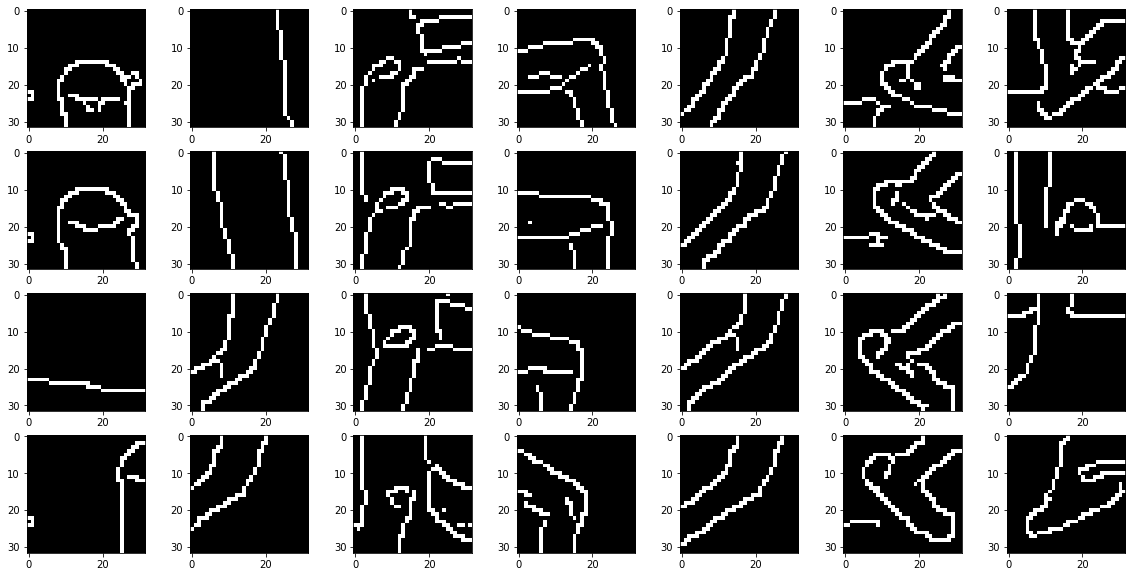

In [11]:
fig, ax = plt.subplots(T, K, figsize=(20, 10))
for t in range(T):
    for k in range(K):
        ax[t, k].imshow(bad_grad[0, t, k, ...].permute(1, 2, 0).cpu().numpy(), cmap='gray')

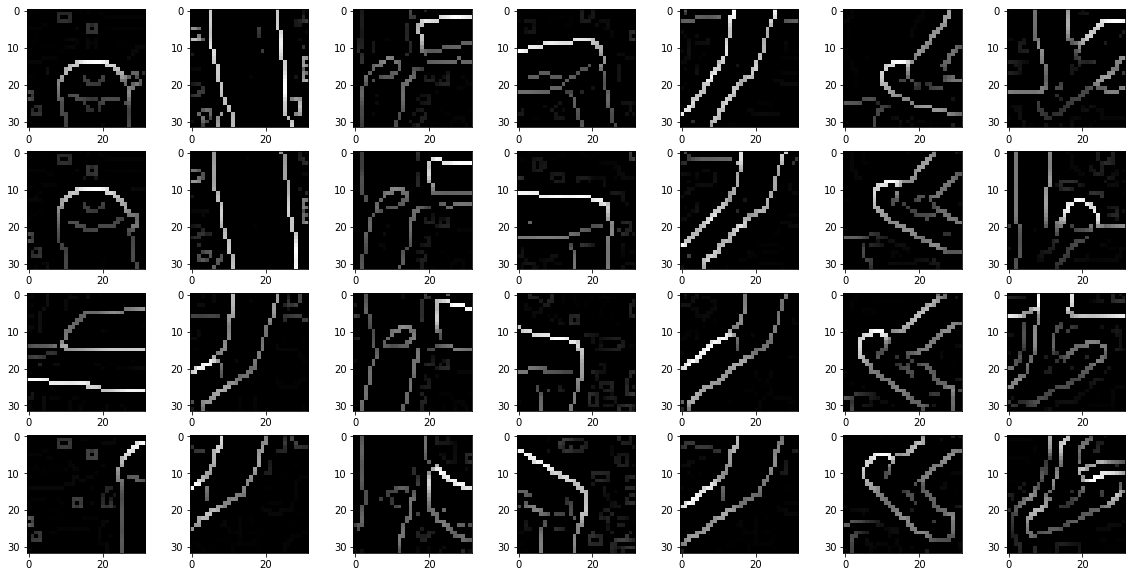

In [12]:
fig, ax = plt.subplots(T, K, figsize=(20, 10))
for t in range(T):
    for k in range(K):
        ax[t, k].imshow(bad_mag[0, t, k, ...].permute(1, 2, 0).cpu().numpy(), cmap='gray')

torch.Size([16, 4, 7, 2])
torch.Size([16, 4, 4, 7])


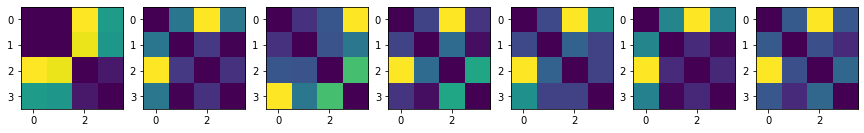

In [13]:
# Temporal difference tensor for bad key-points

bad_grad_avg = torch.mean(bad_grad, dim=[-2, -1])
bad_mag_avg = torch.mean(bad_mag, dim=[-2, -1])

bad_ft = torch.cat([bad_grad_avg, bad_mag_avg], dim=-1)
print(bad_ft.shape)

ft_t_dist = torch.norm(bad_ft.unsqueeze(1) - bad_ft.unsqueeze(2), p=2, dim=-1)**2
print(ft_t_dist.shape)

fig, ax = plt.subplots(1, K, figsize=(15, 10))
for k in range(K):
    ax[k].imshow(ft_t_dist[0, :, :, k].detach().cpu().numpy())
plt.show()

torch.Size([16, 4, 7, 7])


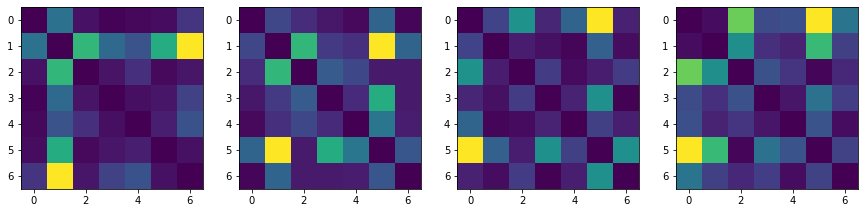

In [14]:
ft_k_dist = torch.norm(bad_ft.unsqueeze(-2) - bad_ft.unsqueeze(-3), p=2, dim=-1)**2
print(ft_k_dist.shape)

fig, ax = plt.subplots(1, T, figsize=(15, 10))
for t in range(T):
    ax[t].imshow(ft_k_dist[0, t, :, :].detach().cpu().numpy())
plt.show()

torch.Size([16, 4, 7, 2])
torch.Size([16, 4, 4, 7])


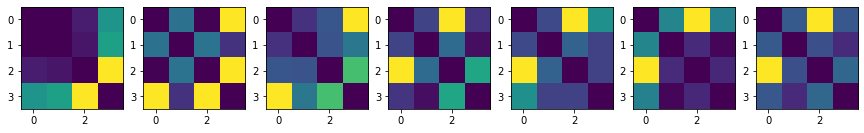

In [15]:
# Temporal difference tensor for perfect key-points

perfect_grad_avg = torch.mean(perfect_grad, dim=[-2, -1])
perfect_mag_avg = torch.mean(perfect_mag, dim=[-2, -1])

perfect_ft = torch.cat([perfect_grad_avg, perfect_mag_avg], dim=-1)
print(perfect_ft.shape)

ft_t_dist = torch.norm(perfect_ft.unsqueeze(1) - perfect_ft.unsqueeze(2), p=2, dim=-1)**2
print(ft_t_dist.shape)

fig, ax = plt.subplots(1, K, figsize=(15, 10))
for k in range(K):
    ax[k].imshow(ft_t_dist[0, :, :, k].detach().cpu().numpy())
plt.show()